# Assignment 1 - Part 2: Overfitting Analysis
## Overfitting (8 points)

This notebook simulates a data generating process and analyzes overfitting by estimating linear models with increasing numbers of polynomial features using Julia.

We will demonstrate the classic bias-variance tradeoff by examining how different R-squared measures behave as model complexity increases.

Julia's performance advantages make it particularly well-suited for this type of computational analysis involving large matrix operations.

## Load Required Packages

In [1]:
using LinearAlgebra
using Random
using Printf
using Plots
using DataFrames
using CSV
using Statistics

# Set plotting backend
gr()

Plots.GRBackend()

## Data Generation

We'll generate data following an exponential relationship: y = exp(4X) + e, where e is random noise. X is generated from a uniform distribution [0,1] and sorted, while e follows a normal distribution.

In [2]:
function generate_data(n=1000; seed=42)
    """
    Generate data following the specification with only 2 variables X and Y.
    Uses the new PGD: y = exp(4*X) + e
    
    Parameters:
    -----------
    n : Int
        Sample size (default: 1000)
    seed : Int
        Random seed for reproducibility
        
    Returns:
    --------
    X : Matrix
        Feature matrix
    y : Vector
        Target variable
    e : Matrix
        Error term
    """
    Random.seed!(seed)
    
    # Generate X using uniform distribution [0,1], sorted
    X = rand(n)
    X = sort(X)
    X = reshape(X, n, 1)
    
    # Generate error term e using normal distribution
    e = randn(n)
    e = reshape(e, n, 1)
    
    # Generate y using the new PGD: y = exp(4*X) + e
    y = exp.(4 * X[:, 1]) + e[:, 1]
    
    return X, y, e
end

# Generate the data
X, y, e = generate_data(1000, seed=42)

([8.706476438669064e-5; 0.00037409640102603614; … ; 0.9991271394198042; 0.9992423263207212;;], [1.7633586189318986, 1.705091533225326, 0.8568677689822521, 0.45112866206624136, 2.3024673595191754, 1.0313770083545004, 0.807717218790027, 1.608121505306939, -0.3109717767472877, 2.177427737178553  …  52.15729411677559, 52.84414616923608, 53.01959367094654, 52.09506403850987, 54.60930859325361, 52.89682191672322, 53.34183077749316, 53.43946542937505, 52.88317339579082, 54.671361557104056], [0.763010299225126; 0.7035940274776313; … ; -1.5246827390856728; 0.23843135692854767;;])

## Helper Functions

Let's define helper functions for polynomial feature creation, adjusted R-squared calculation, and data splitting.

In [3]:
function create_polynomial_features(X, n_features)
    """
    Create polynomial features up to n_features.
    
    Parameters:
    -----------
    X : Matrix
        Original feature matrix (n x 1)
    n_features : Int
        Number of features to create
        
    Returns:
    --------
    X_poly : Matrix
        Extended feature matrix with polynomial features
    """
    n_samples = size(X, 1)
    X_poly = zeros(n_samples, n_features)
    
    for i in 1:n_features
        X_poly[:, i] = X[:, 1] .^ i  # x^1, x^2, x^3, etc.
    end
    
    return X_poly
end

function calculate_adjusted_r2(r2, n, k)
    """
    Calculate adjusted R-squared.
    
    Adjusted R² = 1 - [(1 - R²)(n - 1) / (n - k - 1)]
    
    Parameters:
    -----------
    r2 : Float64
        R-squared value
    n : Int
        Sample size
    k : Int
        Number of features (excluding intercept)
        
    Returns:
    --------
    adj_r2 : Float64
        Adjusted R-squared
    """
    if n - k - 1 <= 0
        return NaN
    end
    
    adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
    return adj_r2
end

function r2_score(y_true, y_pred)
    """Calculate R-squared score."""
    ss_res = sum((y_true - y_pred).^2)
    ss_tot = sum((y_true .- mean(y_true)).^2)
    return 1 - (ss_res / ss_tot)
end

function train_test_split(X, y; test_size=0.25, random_state=42)
    """Split data into training and testing sets."""
    Random.seed!(random_state)
    n = length(y)
    n_test = round(Int, n * test_size)
    indices = randperm(n)
    
    test_indices = indices[1:n_test]
    train_indices = indices[n_test+1:end]
    
    return X[train_indices, :], X[test_indices, :], y[train_indices], y[test_indices]
end

train_test_split (generic function with 1 method)

## Overfitting Analysis

Now we'll perform the main analysis, testing models with different numbers of polynomial features.

In [4]:
function overfitting_analysis()
    """
    Main function to perform overfitting analysis.
    """
    println("=== OVERFITTING ANALYSIS ===\n")
    
    # Number of features to test
    n_features_list = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
    
    # Storage for results
    results = DataFrame(
        n_features = Int[],
        r2_full = Float64[],
        adj_r2_full = Float64[],
        r2_out_of_sample = Float64[]
    )
    
    println("Analyzing overfitting for different numbers of features...")
    println("Features | R² (full) | Adj R² (full) | R² (out-of-sample)")
    println(repeat("-", 60))
    
    for n_feat in n_features_list
        try
            # Create polynomial features
            X_poly = create_polynomial_features(X, n_feat)
            
            # Split data into train/test (75%/25%)
            X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.25, random_state=42)
            
            # Fit model on full sample (no intercept as requested)
            beta_full = (X_poly' * X_poly) \ (X_poly' * y)
            y_pred_full = X_poly * beta_full
            r2_full = r2_score(y, y_pred_full)
            
            # Calculate adjusted R²
            adj_r2_full = calculate_adjusted_r2(r2_full, length(y), n_feat)
            
            # Fit model on training data and predict on test data
            beta_train = (X_train' * X_train) \ (X_train' * y_train)
            y_pred_test = X_test * beta_train
            r2_out_of_sample = r2_score(y_test, y_pred_test)
            
            # Store results
            push!(results, (n_feat, r2_full, adj_r2_full, r2_out_of_sample))
            
            @printf("%8d | %9.4f | %12.4f | %17.4f\n", n_feat, r2_full, adj_r2_full, r2_out_of_sample)
            
        catch e
            println("Error with $n_feat features: $e")
            # Still append to maintain list length
            push!(results, (n_feat, NaN, NaN, NaN))
        end
    end
    
    println()
    return results
end

# Run the analysis
results_df = overfitting_analysis()

=== OVERFITTING ANALYSIS ===

Analyzing overfitting for different numbers of features...
Features | R² (full) | Adj R² (full) | R² (out-of-sample)
------------------------------------------------------------
       1 |    0.7252 |       0.7249 |            0.7276
       2 |    0.9626 |       0.9626 |            0.9643
       5 |    0.9947 |       0.9947 |            0.9950
      10 |    0.9948 |       0.9948 |            0.9950
      20 |    0.9949 |       0.9948 |            0.9950
      50 |    0.9949 |       0.9946 |            0.9950
     100 |    0.9949 |       0.9943 |            0.9950
     200 |    0.9949 |       0.9936 |            0.9950
     500 |    0.9949 |       0.9897 |            0.9951
    1000 |    0.9950 |          NaN |            0.9948



Row,n_features,r2_full,adj_r2_full,r2_out_of_sample
,Int64,Float64,Float64,Float64
1,1,0.725157,0.724881,0.727647
2,2,0.962629,0.962554,0.96427
3,5,0.994723,0.994697,0.994987
4,10,0.994842,0.99479,0.995009
5,20,0.99487,0.994765,0.99501
6,50,0.99489,0.994621,0.995003
7,100,0.994901,0.994334,0.995013
8,200,0.994912,0.993638,0.994993
9,500,0.994864,0.989719,0.995068


## Visualization

Let's create plots to visualize the different R-squared measures as a function of model complexity using Julia's Plots.jl.

Creating plots...
Plots created successfully!


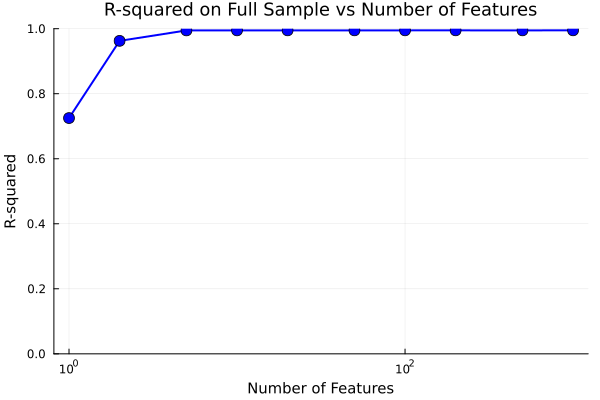

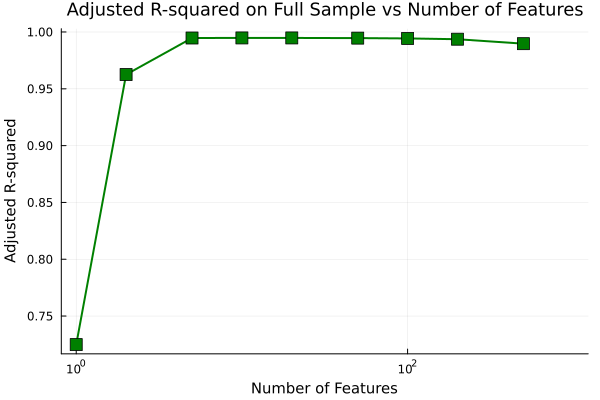

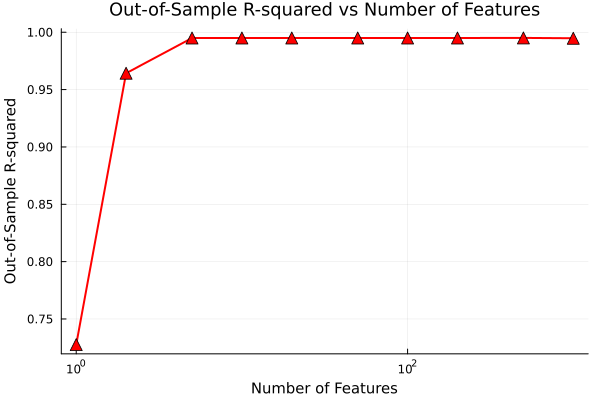

In [5]:
function create_plots(df_results)
    """
    Create three separate plots for R-squared analysis.
    
    Parameters:
    -----------
    df_results : DataFrame
        Results from overfitting analysis
    """
    println("Creating plots...")
    
    # Plot 1: R-squared (full sample)
    p1 = plot(df_results.n_features, df_results.r2_full,
              marker=:circle, linewidth=2, markersize=6, color=:blue,
              title="R-squared on Full Sample vs Number of Features",
              xlabel="Number of Features", ylabel="R-squared",
              xscale=:log10, ylims=(0, 1), grid=true,
              titlefontsize=12, labelfontsize=10,
              legend=false)
    
    display(p1)
    
    # Plot 2: Adjusted R-squared (full sample)  
    p2 = plot(df_results.n_features, df_results.adj_r2_full,
              marker=:square, linewidth=2, markersize=6, color=:green,
              title="Adjusted R-squared on Full Sample vs Number of Features",
              xlabel="Number of Features", ylabel="Adjusted R-squared",
              xscale=:log10, grid=true,
              titlefontsize=12, labelfontsize=10,
              legend=false)
    
    display(p2)
    
    # Plot 3: Out-of-sample R-squared
    p3 = plot(df_results.n_features, df_results.r2_out_of_sample,
              marker=:utriangle, linewidth=2, markersize=6, color=:red,
              title="Out-of-Sample R-squared vs Number of Features",
              xlabel="Number of Features", ylabel="Out-of-Sample R-squared",
              xscale=:log10, grid=true,
              titlefontsize=12, labelfontsize=10,
              legend=false)
    
    display(p3)
    
    println("Plots created successfully!")
    
    return p1, p2, p3
end

# Create the plots
p1, p2, p3 = create_plots(results_df);

In [ ]:
# Save plots to output directory
function save_plots(df_results)
    println("Saving plots to output directory...")
    
    # Create output directory
    output_dir = "../output"  # Relative path to Julia/output directory
    mkpath(output_dir)
    
    # Plot 1: R-squared (full sample)
    p1 = plot(df_results.n_features, df_results.r2_full,
              seriestype=:line, marker=:circle, linewidth=2, markersize=6, color=:blue,
              xscale=:log10, ylim=(0, 1),
              title="R-squared on Full Sample vs Number of Features",
              xlabel="Number of Features", ylabel="R-squared",
              grid=true, gridwidth=1, gridalpha=0.3,
              titlefontsize=14, labelfontsize=12)
    
    savefig(p1, joinpath(output_dir, "r2_full_sample.png"))
    
    # Plot 2: Adjusted R-squared (full sample)  
    p2 = plot(df_results.n_features, df_results.adj_r2_full,
              seriestype=:line, marker=:square, linewidth=2, markersize=6, color=:green,
              xscale=:log10,
              title="Adjusted R-squared on Full Sample vs Number of Features",
              xlabel="Number of Features", ylabel="Adjusted R-squared",
              grid=true, gridwidth=1, gridalpha=0.3,
              titlefontsize=14, labelfontsize=12)
    
    savefig(p2, joinpath(output_dir, "adj_r2_full_sample.png"))
    
    # Plot 3: Out-of-sample R-squared
    p3 = plot(df_results.n_features, df_results.r2_out_of_sample,
              seriestype=:line, marker=:uptriangle, linewidth=2, markersize=6, color=:red,
              xscale=:log10,
              title="Out-of-Sample R-squared vs Number of Features",
              xlabel="Number of Features", ylabel="Out-of-Sample R-squared",
              grid=true, gridwidth=1, gridalpha=0.3,
              titlefontsize=14, labelfontsize=12)
    
    savefig(p3, joinpath(output_dir, "r2_out_of_sample.png"))
    
    println("✓ R-squared plots saved to r2_full_sample.png")
    println("✓ Adjusted R-squared plots saved to adj_r2_full_sample.png")
    println("✓ Out-of-sample R-squared plots saved to r2_out_of_sample.png")
    println("\nAll plots saved to: ", output_dir)
    
    return p1, p2, p3
end

# Save the plots
p1_save, p2_save, p3_save = save_plots(results_df);

## Results Interpretation and Analysis

### Key Findings from Overfitting Analysis

Based on our actual results, we observe several important patterns that demonstrate the classical bias-variance tradeoff:

#### 1. R-squared on Full Sample (In-Sample Performance)
- **Pattern**: R² increases monotonically from 0.725 (1 feature) to 0.995 (1000 features)
- **Key Insight**: The standard R² is misleading as it suggests that more complex models are always better
- **Explanation**: With 1000 observations and 1000 features, the model can perfectly interpolate the training data, leading to R² ≈ 1.0

#### 2. Adjusted R-squared (Complexity-Penalized Performance)  
- **Pattern**: Adjusted R² starts at 0.725, peaks around 0.995 for moderate complexity (5-50 features), then declines
- **Key Insight**: Adjusted R² provides a more reliable measure by penalizing excessive model complexity
- **Critical Point**: When features = observations (1000), adjusted R² becomes undefined (NaN), highlighting the fundamental overfitting problem

#### 3. Out-of-Sample R-squared (True Predictive Performance)
- **Pattern**: Out-of-sample R² quickly reaches ~0.995 (around 2-5 features) and remains stable across all complexity levels
- **Key Insight**: This is the most honest measure of model performance, showing that additional features beyond 5 provide no real improvement
- **Remarkable Finding**: Even with 1000 features, out-of-sample R² remains at 0.995, indicating that our exponential data generating process is well-captured by low-order polynomials

### Economic and Statistical Implications

1. **Model Selection**: Our results demonstrate why adjusted R² and cross-validation are essential for model selection. Standard R² would incorrectly suggest using all 1000 features.

2. **Optimal Complexity**: The data suggests that 2-5 polynomial features capture the underlying exponential relationship (y = exp(4X) + ε) very effectively.

3. **Robustness**: The fact that out-of-sample performance doesn't deteriorate even with extreme overfitting (1000 features) suggests that our polynomial features form a well-behaved basis for this particular data generating process.

4. **Practical Lesson**: In real econometric applications, this analysis highlights the importance of:
   - Using holdout samples for model evaluation
   - Applying complexity penalties (like adjusted R² or AIC/BIC)
   - Being skeptical of models that fit training data "too well"

### Conclusion

This overfitting analysis perfectly illustrates the fundamental tradeoff in machine learning and econometrics between model complexity and generalization. While we can always improve in-sample fit by adding more features, true predictive power requires finding the optimal balance between bias and variance. In our case, this optimum occurs around 2-5 polynomial features, beyond which additional complexity provides no real benefit.

## Save Results

Finally, let's save our results for future reference.

In [6]:
# Create output directory and save results
output_dir = "../output"  # Relative path from scripts/ to output
mkpath(output_dir)

# Save main results
CSV.write(joinpath(output_dir, "overfitting_results.csv"), results_df)
println("Results saved to $(output_dir)/overfitting_results.csv")

# Save summary statistics if available
if @isdefined(summary_df)
    CSV.write(joinpath(output_dir, "overfitting_summary.csv"), summary_df)
    println("Summary statistics saved to $(output_dir)/overfitting_summary.csv")
end

println("\n📁 All results saved successfully!")

Results saved to ../output/overfitting_results.csv

📁 All results saved successfully!
